In [1]:
!pip install pvlib==0.10.4

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
mpl.rcParams['figure.figsize'] = (12, 8)
print(f'pvlib version: {pvlib.__version__}')

pvlib version: 0.10.4


# Self Shade Demo for PVPMC 2024
We compare simple models of linear and non-linear shade loss versus observations. We use [`pvlib.bifacial.infinite_sheds.get_irradiance`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.bifacial.infinite_sheds.get_irradiance.html) to give us shaded fraction for the whole array/row, then manually calculate shaded fraction for each course going up the row. For example, in a 3P crystalline array (`eff_row_side_num_mods = 3`), with an array shaded fraction of 0.5, the shaded fraction in each course, starting from the bottom, would be: 1.0, 0.5, 0.0.

>NOTE: a _course_ is a parallel string in rack or tracker, _AKA_ a row. _EG_: a 2P tracker has 2 courses.

In [3]:
def shade_fractions(fs_array, eff_row_side_num_mods):
    """
    Shade fractions on each _course_ of a rack or tracker.

    Parameters
    ----------
    fs_array : numeric
        Scalar or vector of shade fractions for the entire rack or tracker. Zero (0)
        is unshaded and one (1) is fully shaded.
    eff_row_side_num_mods : int
        Number of courses in the rack as modules. EG: a 2P tracker has 2 courses.

    Returns
    -------
    Array with the shade fraction on each course.
    """
    fs_course = np.clip([
        fs_array * eff_row_side_num_mods - course 
        for course in range(eff_row_side_num_mods)], 0, 1)
    return fs_course

# test examples
shade_fractions(np.array([0.5, 0.6, 2/3]), 3)

array([[1. , 1. , 1. ],
       [0.5, 0.8, 1. ],
       [0. , 0. , 0. ]])

Here's the same thing, but iterating through a range of array shaded fractions (`fs_array`) and plotting the output to confirm it makes sense. Feel free to change the effective number of modules on the side of the row (`eff_row_side_num_mods`).

,0,1,2
fs_array,,,
0,0.000000,0.0,0.000000
1,0.030303,0.0,0.000000
2,0.060606,0.0,0.000000
3,0.090909,0.0,0.000000
4,0.121212,0.0,0.000000
...,...,...,...
95,1.000000,1.0,0.878788
96,1.000000,1.0,0.909091
97,1.000000,1.0,0.939394


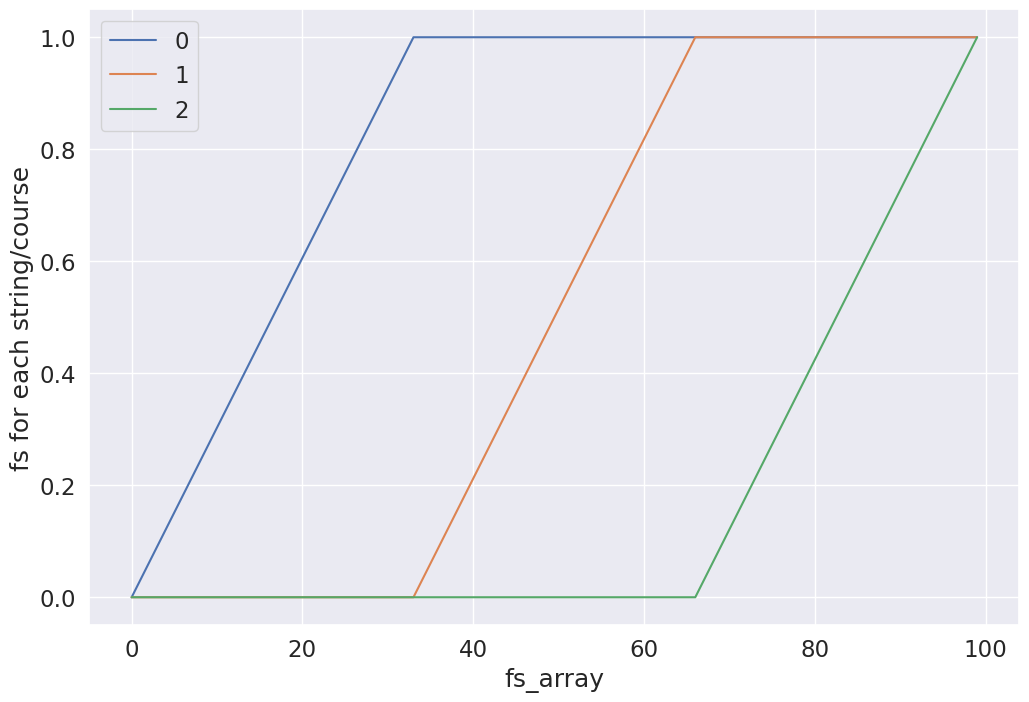

In [4]:
eff_row_side_num_mods = 3 # <-- change this to try other numbers of courses/strings per row
output = shade_fractions(np.linspace(0, 1, 100), eff_row_side_num_mods)
df = pd.DataFrame(output.T)
df.index.name = 'fs_array'
df.plot()
plt.ylabel('fs for each string/course')
df

In [5]:
def non_linear_shade(n_cells_up, fs, fd):
    """
    Simple non-linear shade model.

    Assume shade loss is linear as direct shade moves from bottom through
    first cell, and then only diffuse for remainder of module up to the top.
    EG: If there are 10 cells, and ``fs`` is 0.05, the bottom cell is only
    half shaded, then the loss would be 50% of the direct irradiance. If
    80% of POA global on module is direct irradiance, IE: ``fd = 0.2``,
    then loss would be 40%. When the direct shade line reaches 10%, one
    cell is completely shaded, then the loss is 80%, and there's only diffuse
    light on the module. Any direct shade above the 1st cell has the same loss.

    Parameters
    ----------
    n_cells_up : int
        Number of cells vertically up
    fs : float
        Fraction of shade on module, 1 is fully shaded
    fd : numeric
        Diffuse fraction

    Returns
    -------
    Array of shade loss same size as ``fd``
    """
    pnorm = np.where(fs < 1/n_cells_up, 1 - (1 - fd)*fs*n_cells_up, fd)
    shade_loss = 1 - pnorm
    return shade_loss

In [6]:
def plant_power_with_shade_losses(
    resource_data,
    latitude,
    longitude,
    mount_type,
    gcr,
    dc_capacity_plant,
    power_plant_ac_max,
    dc_loss_fraction,
    gamma_pdc,
    shade_loss_model,
    default_site_transposition_model='haydavies',
    backtrack=pd.NA,
    max_tracker_angle=pd.NA,
    axis_tilt=pd.NA,
    axis_azimuth=pd.NA,
    fixed_tilt=pd.NA,
    fixed_azimuth=pd.NA,
    n_cells_up=12,
    row_side_num_mods=pd.NA,
    row_height_center=pd.NA,
    row_pitch=pd.NA,
    **kwargs,
    ):

    # Fill in some necessary variales with defaults if there is no value provided
    if pd.isna(row_side_num_mods):
        row_side_num_mods = 1 # default if no value provided

    if pd.isna(row_height_center):
        row_height_center = 1 # default if no value provided

    if pd.isna(row_pitch):
        row_pitch = 2 / gcr # default if no value provided

    eta_inv_nom = 0.98

    times = resource_data.index 
    loc = pvlib.location.Location(latitude=latitude, longitude=longitude, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # surface tilt and azimuth
    if mount_type == 'single-axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                apparent_azimuth=solar_position.azimuth,
                                axis_tilt=axis_tilt,
                                axis_azimuth=axis_azimuth,
                                backtrack=backtrack,
                                gcr=gcr,
                                )
        orientation = pvlib.tracking.singleaxis(max_angle=max_tracker_angle,
                                                **singleaxis_kwargs)
        surface_tilt = orientation.surface_tilt.fillna(0)
        surface_azimuth = orientation.surface_azimuth.fillna(0)
    elif mount_type == 'fixed':
        surface_tilt = float(fixed_tilt)
        surface_azimuth = float(fixed_azimuth)

    # dni
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)

    irrad_inf_sh = pvlib.bifacial.infinite_sheds.get_irradiance(
        surface_tilt = surface_tilt, 
        surface_azimuth = surface_azimuth,
        solar_zenith = solar_position.apparent_zenith, 
        solar_azimuth = solar_position.azimuth,
        gcr = gcr, 
        height = row_height_center,
        pitch = row_pitch,
        ghi = resource_data.ghi,
        dhi = resource_data.dhi,
        dni = resource_data.dni,
        albedo = resource_data.albedo,
        model = default_site_transposition_model,
        dni_extra = dni_extra,
        # TODO: add bifaciliaty later if needed...
    )

    # set the "effective" number of modules on the side of each row
    if shade_loss_model == 'non-linear_simple':
        eff_row_side_num_mods = int(row_side_num_mods)
    elif shade_loss_model == 'non-linear_simple_twin_module':
        # twin modules are treated as effectively two modules with half as many cells each
        eff_row_side_num_mods = int(row_side_num_mods) * 2
        n_cells_up = n_cells_up / 2
    # for linear shade loss, it really doesn't matter how many modules there are on the side of each row, so just run everything once to save time
    elif shade_loss_model == 'linear':
        eff_row_side_num_mods = 1 

    # shaded fraction for the whole array (all courses/strings in a row)
    fs_array = irrad_inf_sh['shaded_fraction_front']

    # work backwards to unshaded direct irradiance for the whole array:
    poa_front_direct_unshaded = irrad_inf_sh['poa_front_direct'] / (1-fs_array)

    # total poa on the front, but without direct shade impacts (keeping diffuse impacts from infinite_sheds)
    poa_front_total_without_direct_shade = irrad_inf_sh['poa_front_diffuse'] + poa_front_direct_unshaded

    # shaded fraction for each course/string going up the row
    fs = shade_fractions(fs_array, eff_row_side_num_mods)
    # total POA on the front *with* direct shade impacts for each course/string
    poa_front_total_with_direct_shade = ((1-fs) * poa_front_direct_unshaded.values) + irrad_inf_sh['poa_front_diffuse'].values
    # diffuse fraction for each course/string
    fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values

    # calculate shade loss for each course/string
    if shade_loss_model == 'linear':
        shade_loss = fs * (1 - fd)
    elif shade_loss_model == 'non-linear_simple' or shade_loss_model == 'non-linear_simple_twin_module':
        shade_loss = non_linear_shade(n_cells_up, fs, fd)

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(
        poa_front_total_with_direct_shade, resource_data.temp_air.values, resource_data.wind_speed.values)

    # transient cell temperature, since we are working with intervals shorter than 20 minutes
    # prilliman() cannot be broadcast along 2nd dimension
    # and it requires a series with a datetimeindex - would recommend adding times as an argument or allowing dataframe
    t_cell = np.array([pvlib.temperature.prilliman(pd.Series(t_cell[n], index=times), resource_data.wind_speed).values
                       for n in range(eff_row_side_num_mods)])

    # adjust irradiance based on modeled shade loss
    poa_effective = (1 - shade_loss) * poa_front_total_without_direct_shade.values

    # PVWatts dc power
    pdc_shaded = pvlib.pvsystem.pvwatts_dc(
        poa_effective, t_cell, dc_capacity_plant, gamma_pdc)
    
    pdc_inv = pdc_shaded * (1 - dc_loss_fraction) # dc power into the inverter after losses
        
    # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc0 = power_plant_ac_max/eta_inv_nom 

    # average the dc power across n positions up the row
    pdc_inv_total = pd.DataFrame(pdc_inv.T, index=times).mean(axis=1)

    # ac power with PVWatts inverter model
    power_ac = pvlib.inverter.pvwatts(pdc_inv_total, pdc0, eta_inv_nom)

    return power_ac

Load plant/inverter specs. I have data from 5 anonymous plants and 2 Solar Data Bounty Prize sites. 

For 2 of the anonymous plants, I've pulled data from more than one inverter so that we can look at variation within a plant (since row spacing, tilt, etc., may not be perfectly uniform). "unit_id" values of 30 and 31 are for one of those plants, and 40 and 41 are for the other.

In [7]:
filename = 'plant_specs_pvpmc_rev2.csv'
header = 4 # row (0-index, so starting count at 0) of the header
index_col = 'None'
plants_df = pd.read_csv(filename, header=header).set_index('unit_id') # read in as a Pandas DataFrame
num_plants = len(plants_df.index) # number of plants
plants_df

,Variable:,unit_name,other_name,owner_name,offtaker_name,asset_type,cod,latitude,longitude,altitude,...,strings_per_inverter,num_inverters,module_model,inverter_model,shade_loss_model,n_cells_up,module_length,module_width,module_spec_url,default_site_transposition_model
unit_id,,,,,,,,,,,,,,,,,,,,,
30,NaN,Fixed 2P 72 cell SW,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
31,NaN,Fixed 2P 72 cell SW - inv2,NaN,NaN,NaN,inverter,NaN,31.5000,-84.0000,50.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
10,NaN,Fixed thin film SW,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200.0,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse
20,NaN,Tracking thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-84.5000,200.0,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse
40,NaN,Fixed 2P twin,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100.0,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,26,NaN,NaN,NaN,perez-driesse
41,NaN,Fixed 2P twin - inv2,NaN,NaN,NaN,inverter,NaN,32.5000,-83.5000,100.0,...,NaN,NaN,NaN,NaN,non-linear_simple_twin_module,26,NaN,NaN,NaN,perez-driesse
50,NaN,Fixed 2P 72 cell,NaN,NaN,NaN,inverter,NaN,31.0000,-81.5000,20.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
51,NaN,Fixed 2P 72 cell - inv2,NaN,NaN,NaN,inverter,NaN,31.0000,-81.5000,20.0,...,NaN,NaN,NaN,NaN,non-linear_simple,12,NaN,NaN,NaN,perez-driesse
60,NaN,Fixed thin film,NaN,NaN,NaN,inverter,NaN,32.5000,-116.0000,NaN,...,NaN,NaN,NaN,NaN,linear,1,NaN,NaN,NaN,perez-driesse


/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


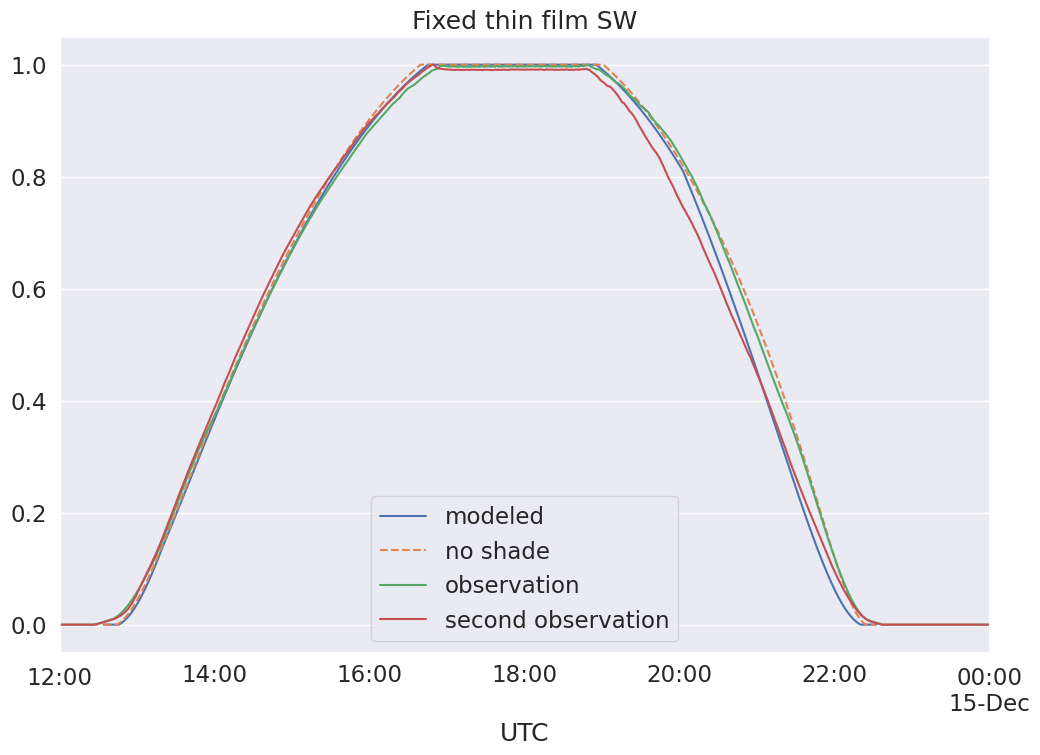

In [8]:
# pick plant/inv unit number:
unit_id = 10
unit_id2 = 11

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

plant_data_new = { **plant_data,
                  'dc_loss_fraction':0.0,
}

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'dc_loss_fraction':0.0,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


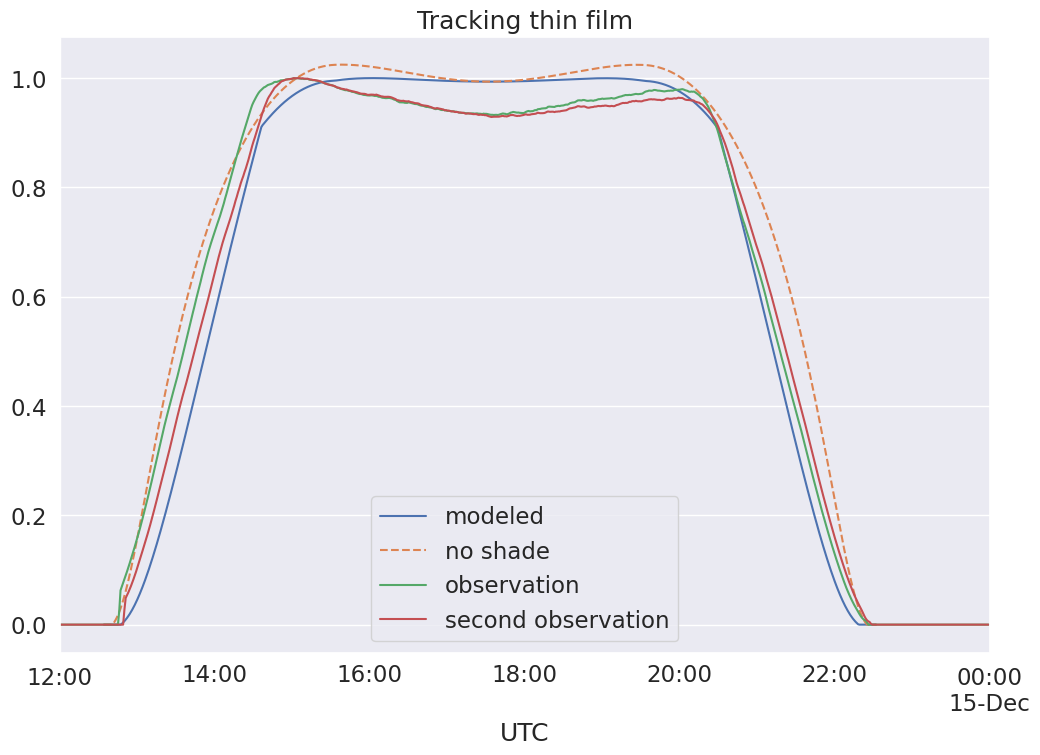

In [9]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


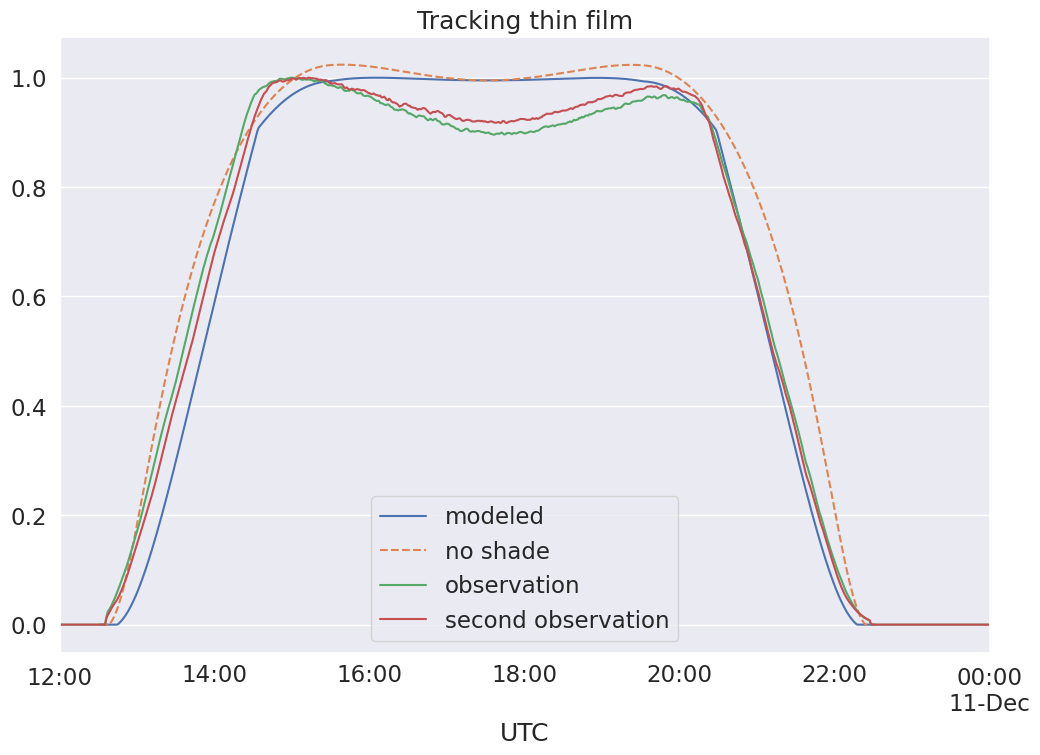

In [10]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
# times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
times = pd.date_range('2017-12-10 12:00', '2017-12-11 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

Again but with `haydavies`:

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


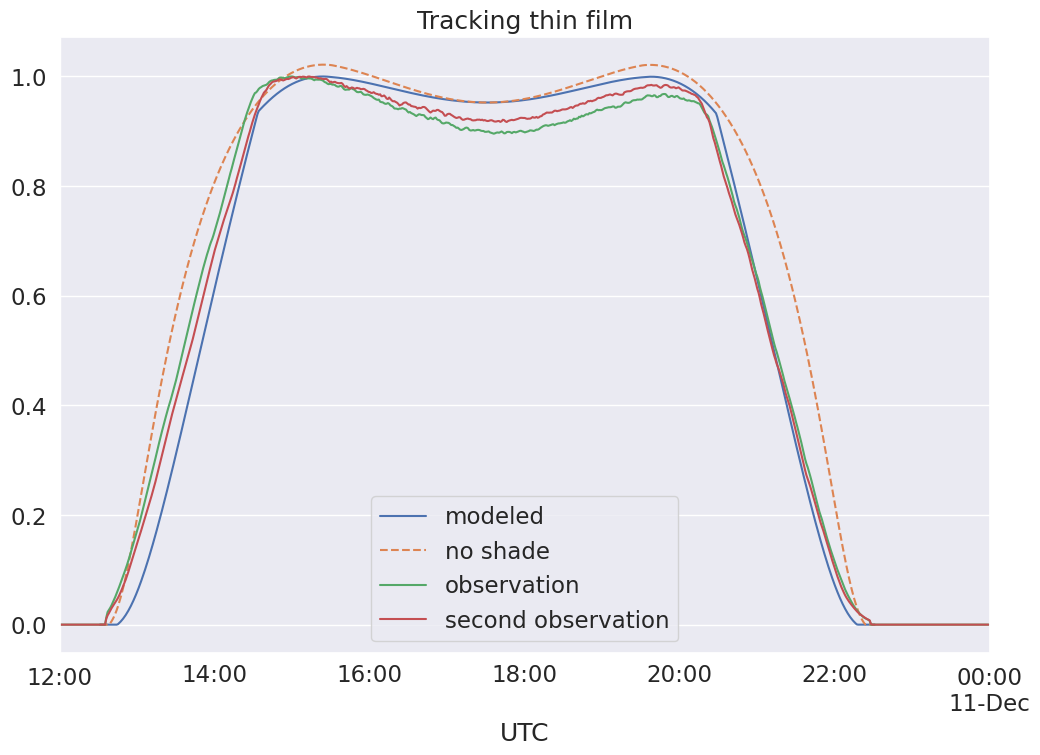

In [11]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
# times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
times = pd.date_range('2017-12-10 12:00', '2017-12-11 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

plant_data_new = { **plant_data,
                  'default_site_transposition_model':'haydavies'
                  }
power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data_new)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  'default_site_transposition_model':'haydavies'
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


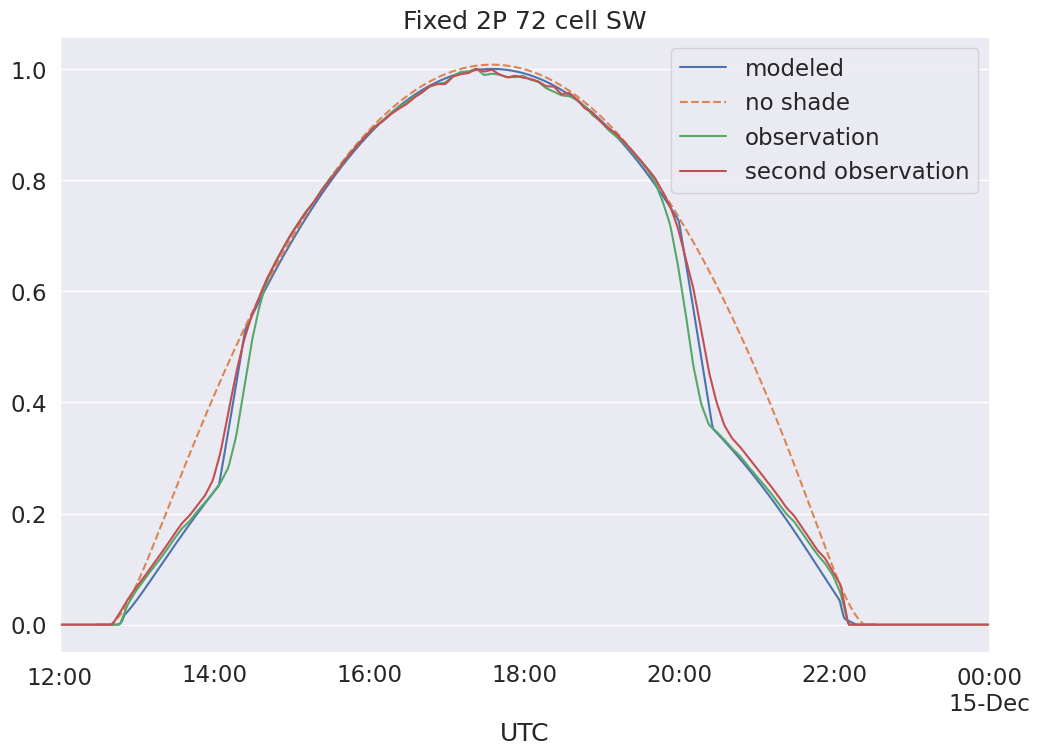

In [12]:
# pick plant/inv unit number:
unit_id = 30
unit_id2 = 31

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


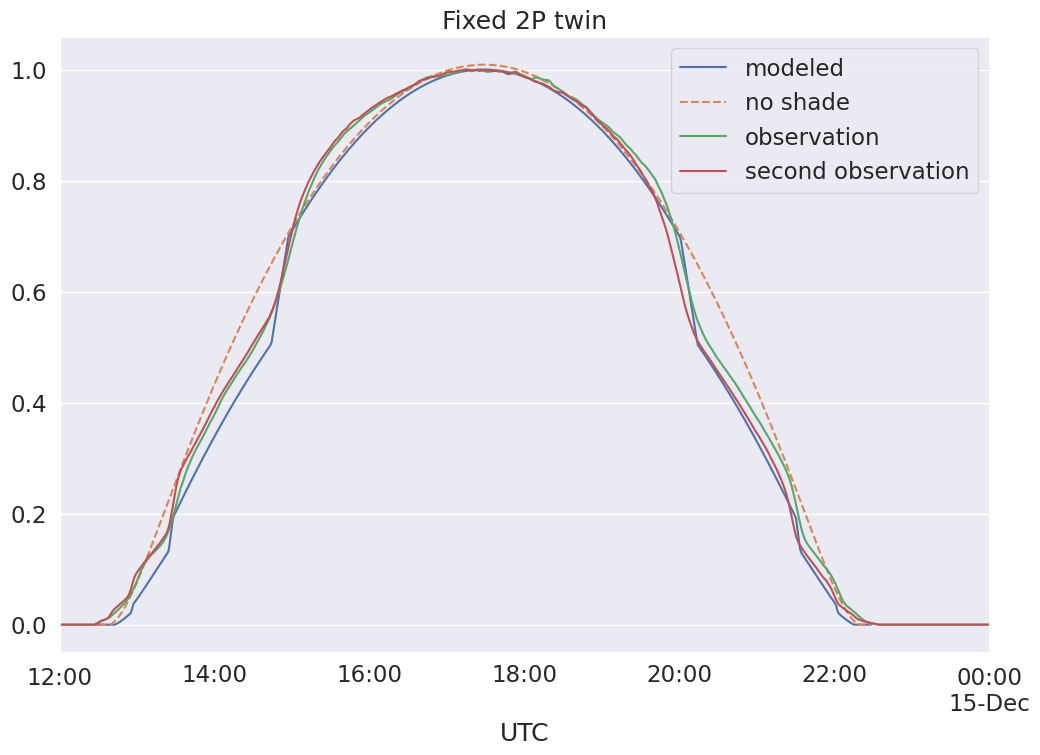

In [13]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


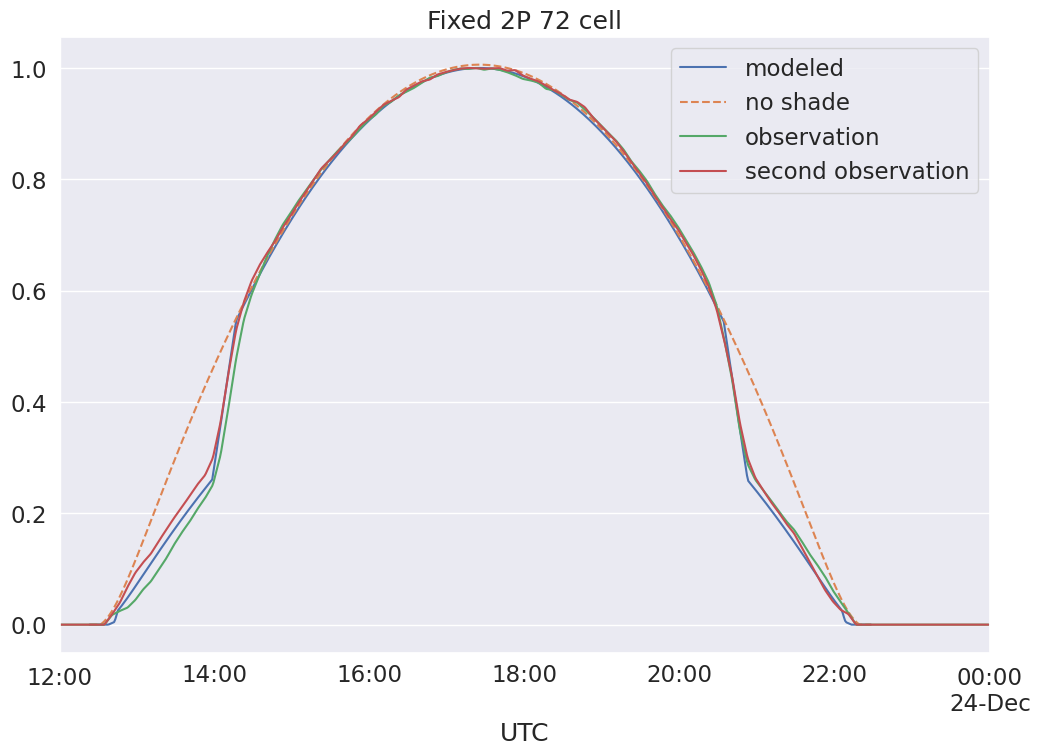

In [14]:
# pick plant/inv unit number:
unit_id = 50
unit_id2 = 51

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-23 12:00', '2021-12-24 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


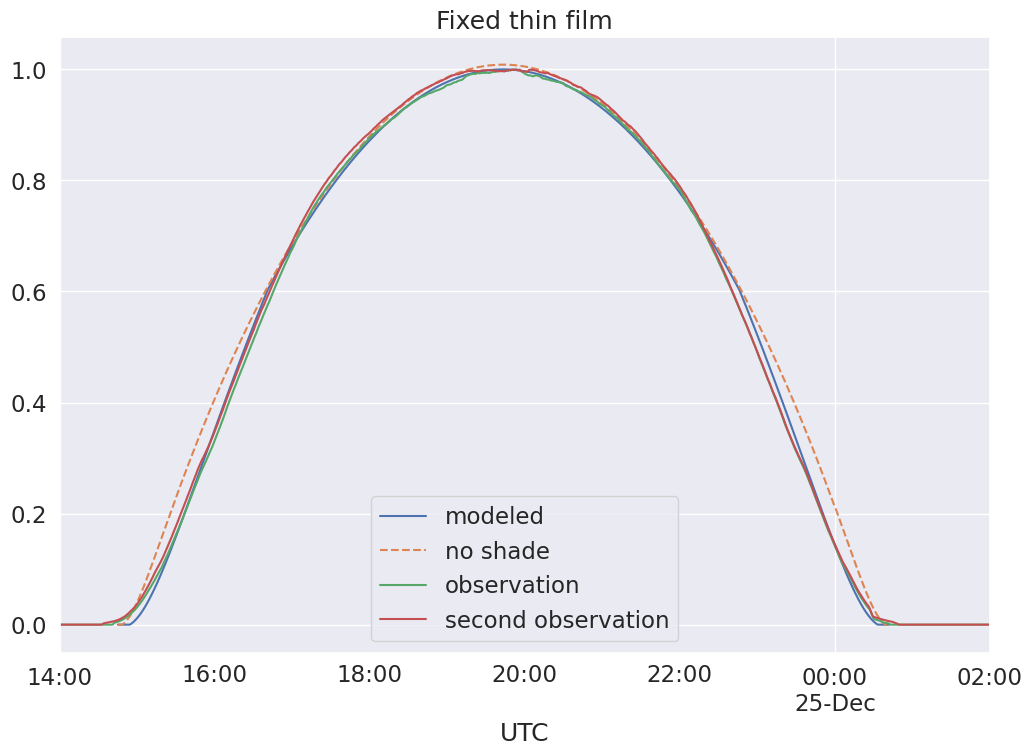

In [15]:
# pick plant/inv unit number:
unit_id = 60
unit_id2 = 61

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2022-12-24 14:00', '2022-12-25 02:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)
resource_data = loc.get_clearsky(times)
resource_data['temp_air'] = 15 # use 15 deg C as generic value
resource_data['wind_speed'] = 2 # use 2 m/s as generic value
resource_data['albedo'] = 0.2 # use 0.2 as a generic value

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled / power_ac_modeled.max()).plot(ax=ax)
(power_ac_no_shade / power_ac_modeled.max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name']);

Now try with NSRDB:

In [16]:
## API key credentials are stored in a separate text file
try:
    with open('credentials/nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        api_key = f.readline().rstrip()
except:
    print('error with email and API key, using temporary defaults')
    print('register at https://developer.nrel.gov/')
    print('create the folder and text file referenced above with email on first line and API key on second line')
    api_key = 'DEMO_KEY'
    email = 'your_email@domain.com'

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


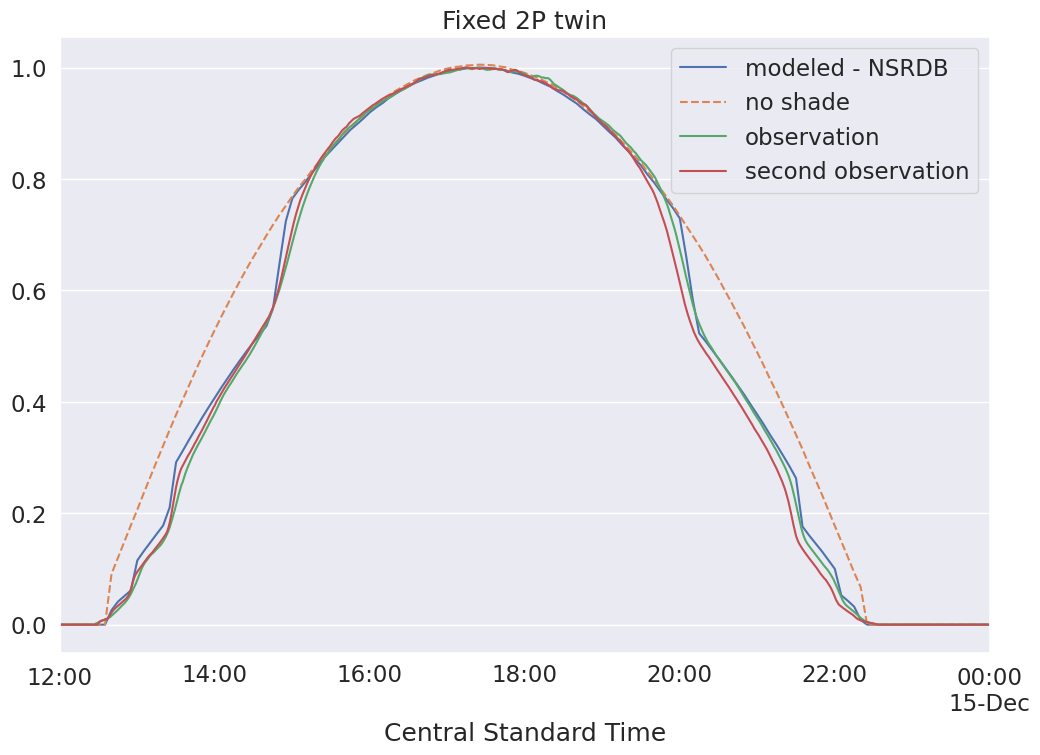

In [17]:
# pick plant/inv unit number:
unit_id = 40
unit_id2 = 41

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

GCR tuning test:

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: in

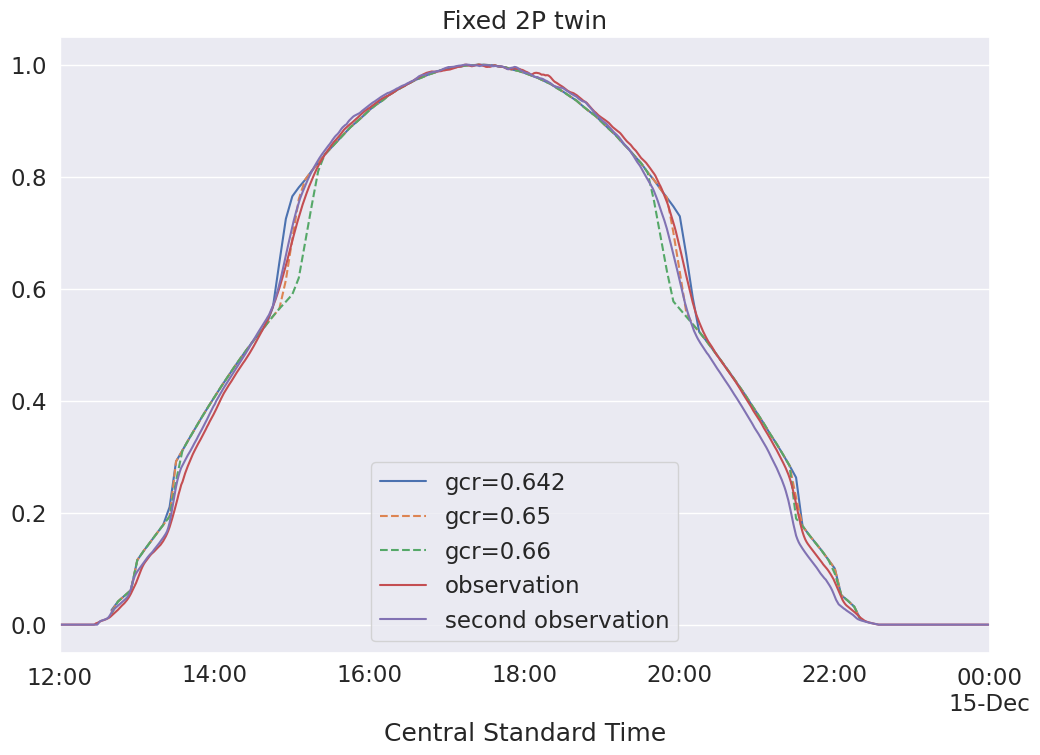

In [18]:
power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

plant_data_new = { **plant_data,
                  'gcr':0.65,
}
power_ac_modeled_tuned = plant_power_with_shade_losses(resource_data, **plant_data_new)

plant_data_new = { **plant_data,
                  'gcr':0.66,
}
power_ac_modeled_tuned2 = plant_power_with_shade_losses(resource_data, **plant_data_new)

f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]] / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_modeled_tuned.loc[times[0]:times[-1]] / power_ac_modeled_tuned.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_ac_modeled_tuned2.loc[times[0]:times[-1]] / power_ac_modeled_tuned2.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['gcr=0.642', 'gcr=0.65', 'gcr=0.66', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


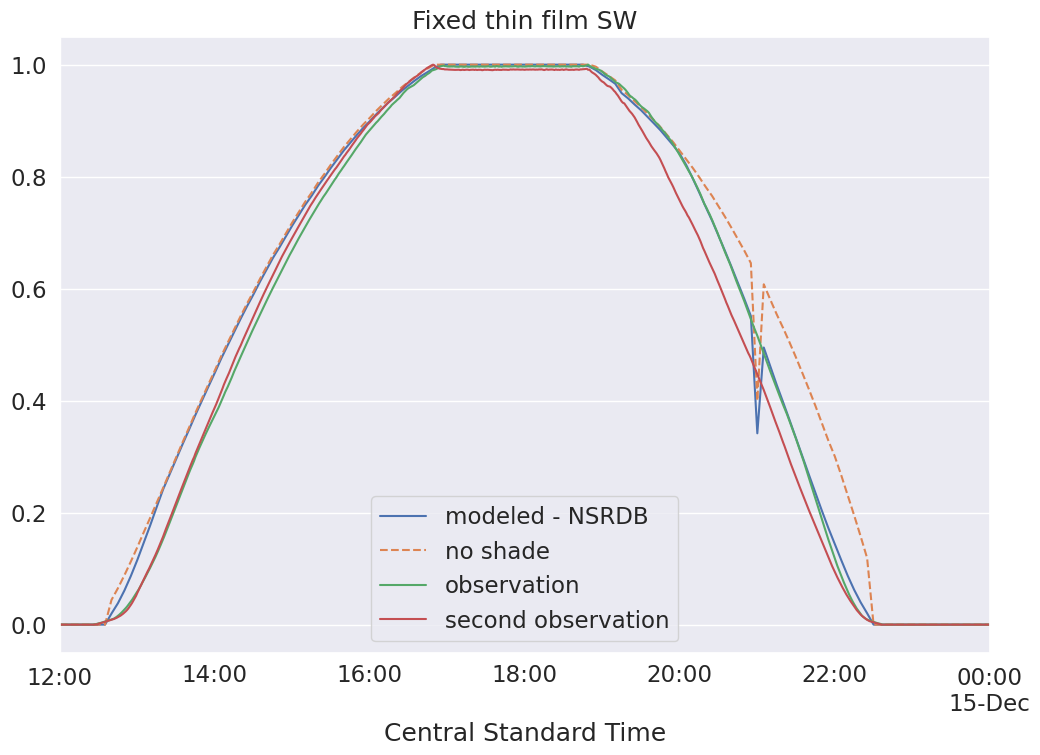

In [19]:
# pick plant/inv unit number:
unit_id = 10
unit_id2 = 11

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation','second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


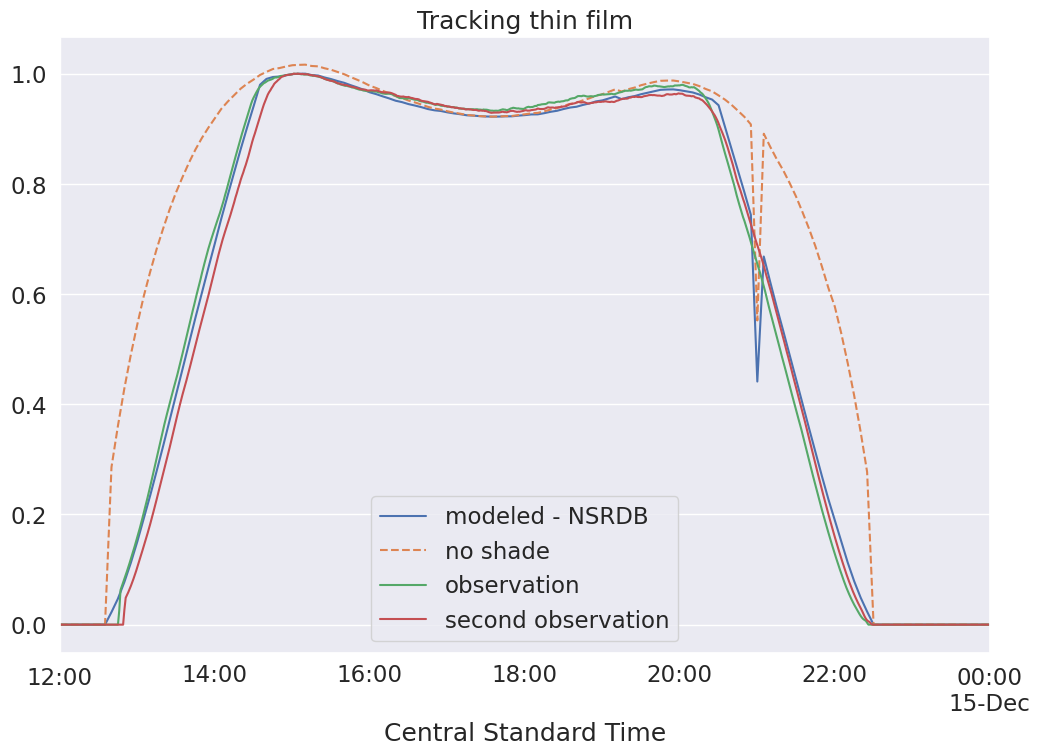

In [20]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation','second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1003: UserWarning: temperature.prilliman only applies smoothing when the sampling interval is shorter than 20 minutes (input sampling interval: 30.0 minutes); returning input temperature series unchanged
  warnings.warn("temperature.prilliman only applies smoothing when "
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1003: UserWarning: temperature.prilliman only applies smoothing when the sampling interval is shorter than 20 minutes (input sampling interval: 30.0 minutes); returning input temperature series unchanged

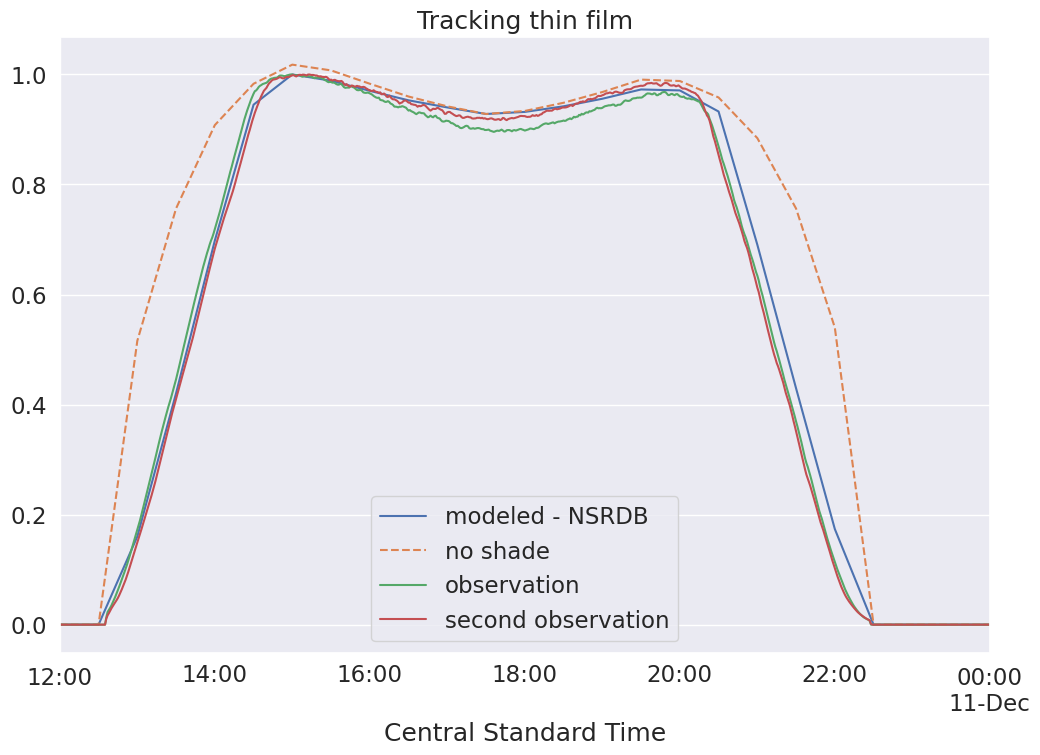

In [21]:
# pick plant/inv unit number:
unit_id = 20
unit_id2 = 21

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + 'b.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2017-12-10 12:00', '2017-12-11 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2017',
                                                 interval=30,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


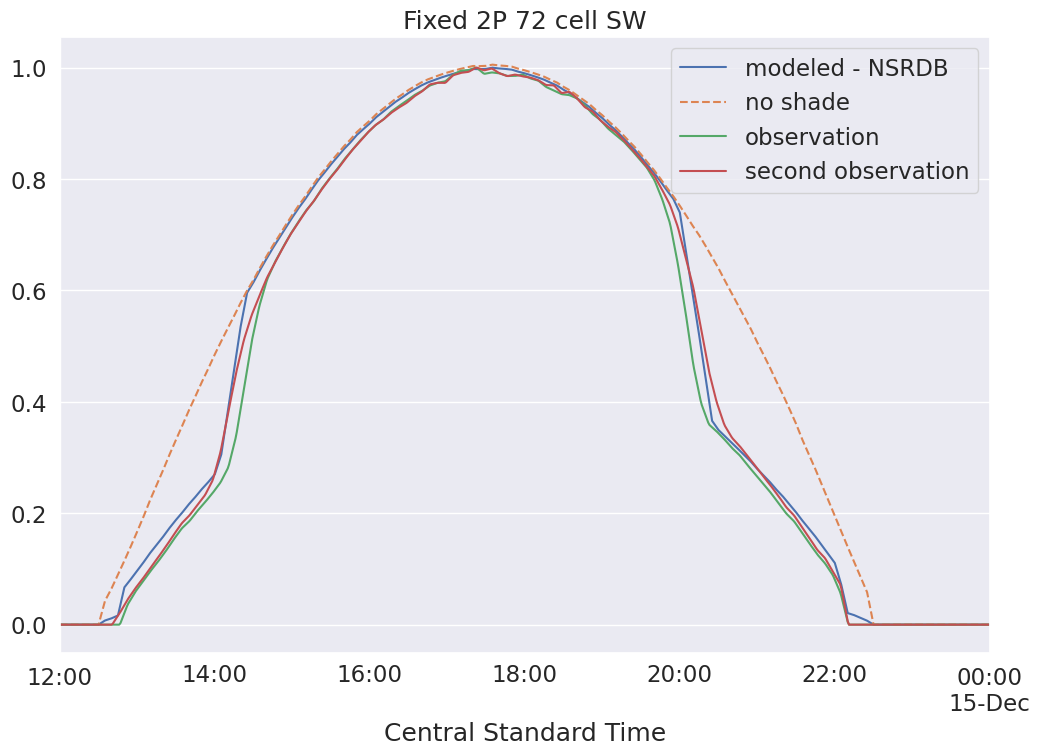

In [22]:
# pick plant/inv unit number:
unit_id = 30
unit_id2 = 31

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-14 12:00', '2021-12-15 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


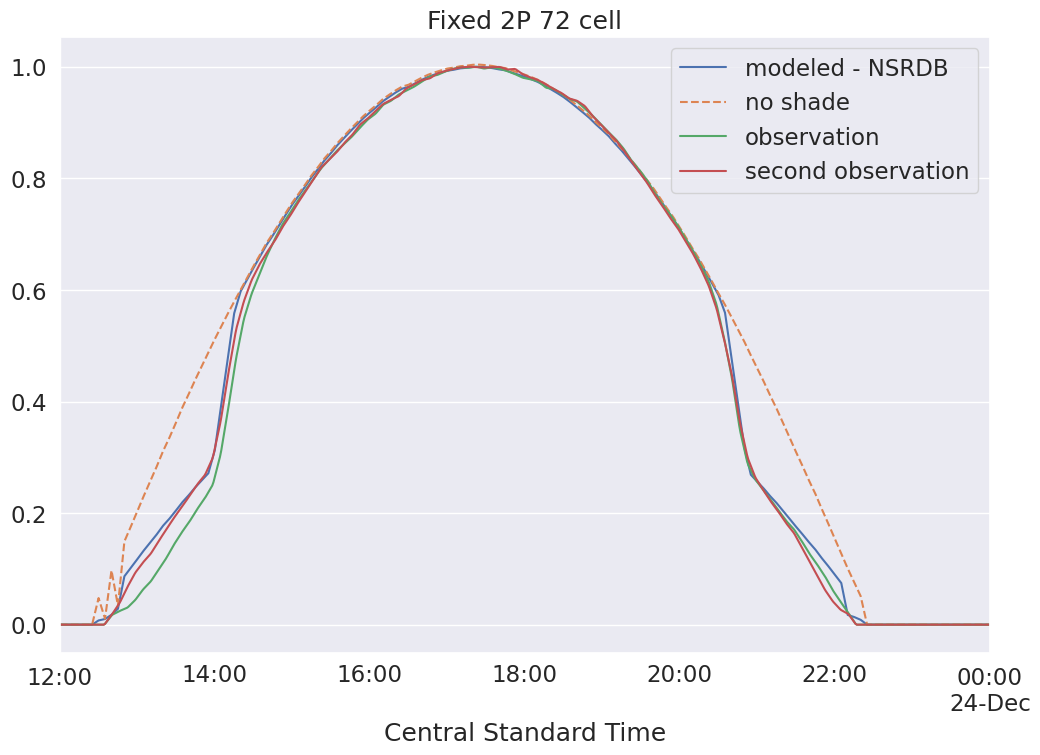

In [23]:
# pick plant/inv unit number:
unit_id = 50
unit_id2 = 51

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2021-12-23 12:00', '2021-12-24 00:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2021',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');

/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values
/home/huracan-mikm/.local/lib/python3.11/site-packages/pvlib/temperature.py:1089: RuntimeWarning: invalid value encountered in divide
  smoothed = numerator / denominator
/tmp/ipykernel_50503/2038154576.py:105: RuntimeWarning: invalid value encountered in divide
  fd = irrad_inf_sh['poa_front_diffuse'].values / poa_front_total_without_direct_shade.values


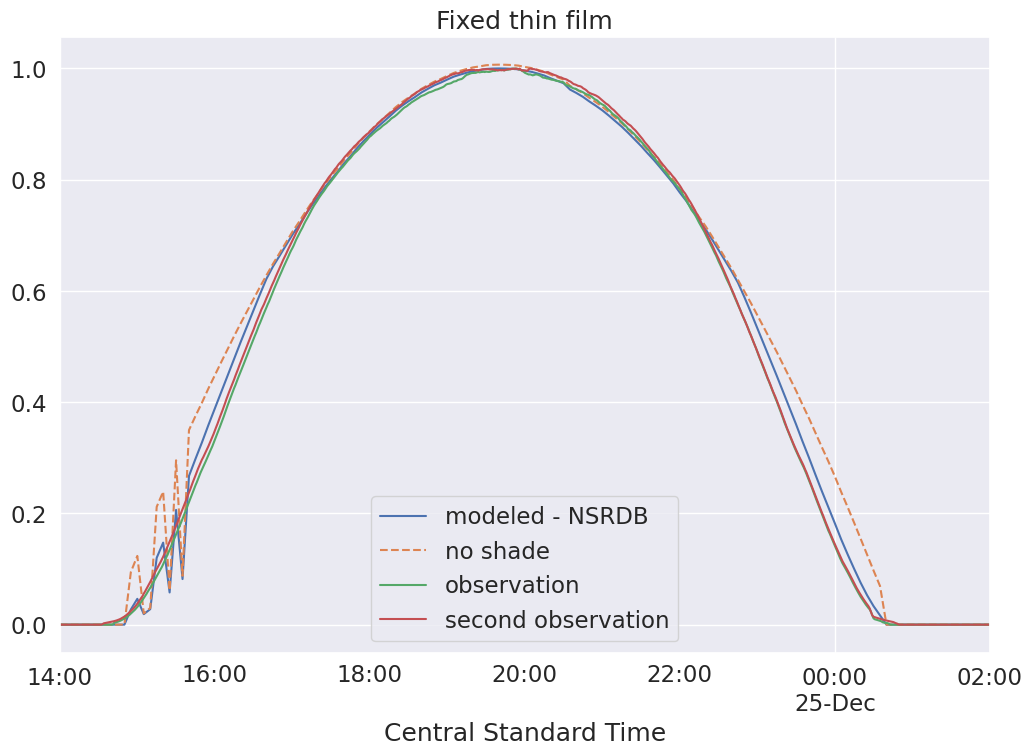

In [24]:
# pick plant/inv unit number:
unit_id = 60
unit_id2 = 61

# read in normalized observed power from a reference plant
power_obs = pd.read_csv('sample_data/plant_' + str(unit_id) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs.index = power_obs.index.tz_localize('UTC')
power_obs2 = pd.read_csv('sample_data/plant_' + str(unit_id2) + '.csv',
                        index_col=0,
                        parse_dates=["UTC"])
power_obs2.index = power_obs2.index.tz_localize('UTC')

# convert row of dataframe to a dictionary to be passed to power function
plant_data = plants_df.loc[unit_id].dropna().to_dict() 

# make some clear sky resource data. Can replace with NSRDB data later
times = pd.date_range('2022-12-24 14:00', '2022-12-25 02:00', freq='1min', tz='UTC')
loc = pvlib.location.Location(latitude=plant_data['latitude'], longitude=plant_data['longitude'], tz=times.tz)

resource_data, metadata = pvlib.iotools.get_psm3(plant_data['latitude'],
                                                 plant_data['longitude'],
                                                 api_key,
                                                 email,
                                                 names='2022',
                                                 interval=5,
                                                 map_variables=True,
                                                 leap_day=True,
                                                 )
# convert to UTC, adjust metadata to match
resource_data.index = resource_data.index.tz_convert('UTC')
metadata['Time Zone'] = 0

power_ac_modeled = plant_power_with_shade_losses(resource_data, **plant_data)

# negligible shade w/ linear loss model
plant_data_new = { **plant_data,
                  'gcr':0.00000001,
                  'row_side_num_mods':1,
                  'shade_loss_type':'linear',
                  'cell_type':'thin-film',
                  }
power_ac_no_shade = plant_power_with_shade_losses(resource_data, **plant_data_new)

# plot
f, ax = plt.subplots(1, 1)
(power_ac_modeled.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax)
(power_ac_no_shade.loc[times[0]:times[-1]].fillna(0) / power_ac_modeled.loc[times[0]:times[-1]].max()).plot(ax=ax, linestyle='--')
(power_obs / power_obs.max()).plot(ax=ax)
(power_obs2.observed_power / power_obs2.observed_power.max()).plot(ax=ax)
plt.legend(['modeled - NSRDB', 'no shade', 'observation', 'second observation'])
plt.title(plant_data['unit_name'])
plt.xlabel('Central Standard Time');